<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

<img title="Moby Bikes" src="https://i.ytimg.com/vi/-s8er6tHD3o/maxresdefault.jpg" style="height:400px; border-radius: 10px" alt="Moby Bikes" class="img-fluid">

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">&nbsp;Table of Contents:</h1>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">1. Introduction<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages">2. Feature Engineering<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="messages">3. EDA (Exploratory Data Analysis)<span class="badge badge-primary badge-pill">3</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="messages">4. Model<span class="badge badge-primary badge-pill">4</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="messages">5. Evaluation<span class="badge badge-primary badge-pill">5</span></a>    
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="messages">6. Conclusion<span class="badge badge-primary badge-pill">6</span></a>
</div>

---

<a id="1"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">1- Introduction</p>

## Datasets

Dataset provided by [Moby Bikes](https://data.gov.ie/dataset/moby-bikes) through a public [API](https://data.smartdublin.ie/mobybikes-api). 

Dataset provided by [Met Éireann](https://www.met.ie/) through a public [API](https://data.gov.ie/organization/meteireann). 


The **aim** of this report is to map how this disease spread throughout the island and provide insights on possible spots and species that might need extra attention from the scientists who investigate this constant threat to resident birds.

## Questions

- What species have shown to be the most affected with Bird Flu?
- What are the most frequent locations where captured birds have been detected with Avian Flu?
- November is the month with the highest presence as mentioned? What are the months with the highest proportion of infected birds?
- The percentage of infected birds have increased during the years?
- What is the proportion of birds targeted with Avian Flu on each Council / County?
- Which areas present statistically significant incidence of Bird Flu?


>https://mobidev.biz/blog/machine-learning-methods-demand-forecasting-retail

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
from conn import mongodb
import importlib
from pymongo import MongoClient
from urllib.parse import quote_plus
importlib.reload(mongodb)

<module 'conn.mongodb' from '/Users/pessini/Dropbox/Data-Science/moby-bikes/notebooks/conn/mongodb.py'>

In [3]:
def _connect_mongo(host, port, username, password, db_name):
    """ A util for making a connection to mongo """

    if username and password:
        try:
            mongo_uri = f'mongodb://{username}:{quote_plus(password)}@{host}:{port}/{db_name}'
            conn = MongoClient(mongo_uri)
        except:
            print('Could not connect to MongoDB')
    else:
        conn = MongoClient(host, port)

    return conn

In [4]:
def read_mongo(query={}, collection='', no_id=True):
    """ Read from Mongo and Store into a DataFrame """
    df = None
    try:
        # Connect to MongoDB
        conn = _connect_mongo(host=mongodb.host, port=mongodb.port, username=mongodb.user_name, password=mongodb.pass_word, db_name=mongodb.db_name)
        db = conn.mobybikes # switch to the database

        if collection in db.list_collection_names():
            
            # Make a query to the specific DB and Collection and store into a Dataframe
            data = db[collection].find(query)
            df =  pd.DataFrame(list(data))
            
            # Delete the _id
            if no_id:
                del df['_id']
        else:
            print(f'Collection {collection} was not found!')
            pass

        # close mongodb connection
        conn.close()
    except:
        print('Could not query MongoDB')
    
    return df


In [5]:
# from bson.objectid import ObjectId

# query = {
#     '_id': ObjectId('60f71005df6b1188a680219b')
# }

historical_data = read_mongo(collection='historical')

In [6]:
historical_data.columns = historical_data.columns.str.lower()
historical_data.head()

,harvesttime,bikeid,battery,ebikestateid,lastgpstime,lastrentalstart,latitude,longitude
0,2021-04-01 00:00:03,5,7.0,2,2021-03-31 23:41:40,2021-03-30 19:18:18,53.3091,-6.21643
1,2021-04-01 00:00:03,6,16.0,2,2021-03-31 23:55:41,2021-03-31 10:31:13,53.3657,-6.32249
2,2021-04-01 00:00:03,7,66.0,2,2021-03-31 23:42:04,2021-03-30 13:07:19,53.2799,-6.14497
3,2021-04-01 00:00:03,8,48.0,2,2021-03-31 23:52:26,2021-03-30 12:43:17,53.2891,-6.11378
4,2021-04-01 00:00:03,9,-6.0,2,2021-03-31 23:50:20,2021-03-29 22:37:58,53.2928,-6.13014


In [7]:
historical_data.isnull().sum()

harvesttime            0
bikeid                 0
battery            25342
ebikestateid           0
lastgpstime            0
lastrentalstart        0
latitude               0
longitude              0
dtype: int64

## Weather Data - Met Éireann

About the weather data there are two important decisions. One is about from **which station** the **historical data will be collected** and the other one is about the **frequency of data**, which can be **hourly or daily**.

### Station Name: **PHOENIX PARK**

In [10]:
phoenixpark_weather_hourly = pd.read_csv('../data/raw/hly175.csv')
phoenixpark_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,16-aug-2003 01:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95,1021.9
1,16-aug-2003 02:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96,1021.7
2,16-aug-2003 03:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96,1021.2
3,16-aug-2003 04:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97,1021.2
4,16-aug-2003 05:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97,1021.1


In [11]:
phoenixpark_weather_daily = pd.read_csv('../data/raw/dly175.csv')
phoenixpark_weather_daily.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,soil
0,16-aug-2003,0,20.1,0,7.5,4,,0,0.0,1013.7,18.565
1,17-aug-2003,0,21.3,0,11.6,0,7.5,0,1.1,1007.5,18.280
2,18-aug-2003,0,20.3,0,8.5,0,4.3,0,0.0,1008.8,17.825
3,19-aug-2003,0,19.9,0,11.3,0,7.7,0,0.0,1014.3,18.138
4,20-aug-2003,0,21.5,0,10.8,0,6.9,0,0.0,1013.6,18.432


### Station Name: **DUBLIN AIRPORT**

In [12]:
dublin_airport_weather_hourly = pd.read_csv('../data/raw/hly532.csv')
dublin_airport_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01-jan-1991 00:00,3,0.0,0,2.1,0,1.4,0.2,6.2,87,...,2,11,2,230,2,11,0.0,40000,999,0
1,01-jan-1991 01:00,3,0.0,0,2.0,0,1.0,-0.8,5.8,82,...,2,11,2,230,2,11,0.0,40000,999,2
2,01-jan-1991 02:00,3,0.0,0,1.9,0,0.9,-0.9,5.7,82,...,2,8,2,220,2,11,0.0,40000,200,6
3,01-jan-1991 03:00,3,0.0,0,2.6,0,1.3,-1.1,5.7,77,...,2,9,2,220,2,11,0.0,40000,999,4
4,01-jan-1991 04:00,3,0.0,0,4.0,0,2.2,-0.9,5.7,70,...,2,9,2,200,2,11,0.0,40000,120,7


## Phoenix Park Station vs Dublin Aiport Station
Geographically, the station at Phoenix Park would be the most suitable choice but unfortunately, they do not collect Wind information which in Ireland plays an important role when deciding to go cycling or not. For those who are not familiar with Irish weather, it rains a lot and mostly we do not have much choice about it but the wind is something that can prevent you go outside or choose a different kind of transport. Heavy rain is kind of rare on the other hand.

## Hourly vs Daily data
On this subject, daily data for the business would make more sense but because the weather is so unpredictable in Ireland (it can completely change in an hour), the best option would be hourly especially if we are looking at a historical perspective. For simplicity and better planning, we can always aggregate the predicted results by day.

In [13]:
dublin_airport_weather_hourly['date'] = pd.to_datetime(dublin_airport_weather_hourly['date'])

In [14]:
dublin_airport_weather_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267337 entries, 0 to 267336
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    267337 non-null  datetime64[ns]
 1   ind     267337 non-null  int64         
 2   rain    267337 non-null  float64       
 3   ind.1   267337 non-null  int64         
 4   temp    267337 non-null  float64       
 5   ind.2   267337 non-null  int64         
 6   wetb    267337 non-null  float64       
 7   dewpt   267337 non-null  float64       
 8   vappr   267337 non-null  object        
 9   rhum    267337 non-null  object        
 10  msl     267337 non-null  float64       
 11  ind.3   267337 non-null  int64         
 12  wdsp    267337 non-null  int64         
 13  ind.4   267337 non-null  int64         
 14  wddir   267337 non-null  object        
 15  ww      267337 non-null  int64         
 16  w       267337 non-null  int64         
 17  sun     267337 non-null  floa

In [15]:
recent_dubairport_data = dublin_airport_weather_hourly.copy()

start_date_hist = datetime(2020, 9, 23) # first day registered
end_date_hist = datetime(2021, 6, 30) # last day used as historical data

recent_dubairport_data = recent_dubairport_data[(recent_dubairport_data.date >= start_date_hist) & (recent_dubairport_data.date <= end_date_hist)]

In [16]:
len(dublin_airport_weather_hourly), len(recent_dubairport_data)

(267337, 6721)

## Hypothesis

Hourly trend: There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.

Daily Trend: Registered users demand more bike on weekdays as compared to weekend or holiday.

Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.

Temperature: In Ireland, temperature has positive correlation with bike demand.

Time: Total demand should have higher contribution of registered user as compared to casual because registered user base would increase over time.

Traffic: It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc.



<a id="2"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">2- Feature Engineering</p>

### New Features
- date (yyyy-mm-dd)
- month
- hour
- workingday
- holiday
- season
- battery_start
- battery_end
- path? (multi polygon)
- rental_duration


The number of rentals each hour will be aggregate later with a new feature `count`.

In [17]:
rentals_data = historical_data.drop(['harvesttime','ebikestateid'], axis=1).copy()
rentals_data[["lastgpstime", "lastrentalstart"]] = rentals_data[["lastgpstime", "lastrentalstart"]].apply(pd.to_datetime)

rentals_data = rentals_data.astype({'battery': np.int16}, errors='ignore') # errors ignore to keep missing values (not throwing error)

In [18]:
rentals_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960928 entries, 0 to 960927
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   bikeid           960928 non-null  int64         
 1   battery          935586 non-null  float64       
 2   lastgpstime      960928 non-null  datetime64[ns]
 3   lastrentalstart  960928 non-null  datetime64[ns]
 4   latitude         960928 non-null  float64       
 5   longitude        960928 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 44.0 MB


### Rentals' information

- `coordinates`: converting latitude and longitude to an array to store a GeoJSON object *MultiPoint* 
- `start_battery`: getting the battery status when the rental started
- `lastgpstime`: new variable that will only store the last record when grouping rentals

In [19]:
def feat_eng(x):
    d = {}
    d['coordinates'] = x[['latitude','longitude']].values.tolist()
    d['start_battery'] = list(x['battery'])[-1] # get the first battery status (when rental started)
    d['lastgpstime'] = list(x['lastgpstime'])[0] # get the last gpstime (previously sorted)
    
    return pd.Series(d, index=['coordinates', 'start_battery', 'lastgpstime'])

# also sorting data by lastgpstime
grouped_rentals = rentals_data.sort_values("lastgpstime", ascending=False).groupby(['lastrentalstart', 'bikeid']).apply(feat_eng).reset_index()

In [20]:
grouped_rentals.shape

(27534, 5)

### Date and time - new features
- `rental_date`
- `rental_month`
- `rental_hour`
- `holiday`
- `workingday`
- `season`: (1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter)
- *`duration`: duration of the rental

\* **Assumption**: that the duration of the rental is $ LastGPSTime - RentalStart $

In [21]:
grouped_rentals['rental_date'] = pd.to_datetime(grouped_rentals['lastrentalstart'].dt.date)
grouped_rentals['rental_month'] = grouped_rentals['lastrentalstart'].dt.month
grouped_rentals['rental_hour'] = grouped_rentals['lastrentalstart'].dt.hour

In [22]:
grouped_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27534 entries, 0 to 27533
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   lastrentalstart  27534 non-null  datetime64[ns]
 1   bikeid           27534 non-null  int64         
 2   coordinates      27534 non-null  object        
 3   start_battery    26963 non-null  float64       
 4   lastgpstime      27534 non-null  datetime64[ns]
 5   rental_date      27534 non-null  datetime64[ns]
 6   rental_month     27534 non-null  int64         
 7   rental_hour      27534 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(3), object(1)
memory usage: 1.7+ MB


In [23]:
# time of rental in minutes (lastgpstime - rental-start)
grouped_rentals['duration'] = (grouped_rentals['lastgpstime'] - grouped_rentals['lastrentalstart']) / pd.Timedelta(minutes=1)

## Bank Holidays

In [24]:
qry_bh = {
    'type': 'National holiday'
}

bank_holidays = read_mongo(query=qry_bh, collection='irishcalendar')
bank_holidays.drop(['country', 'type'], axis=1, inplace=True)
bank_holidays['date'] = pd.DatetimeIndex(bank_holidays['date'].apply(pd.to_datetime))

In [25]:
# holiday
grouped_rentals['holiday'] = grouped_rentals['rental_date'].isin(bank_holidays['date'])

# day of the week
grouped_rentals['dayofweek'] = grouped_rentals['rental_date'].dt.dayofweek

# working day (Monday=0, Sunday=6)
grouped_rentals['working_day'] = grouped_rentals['dayofweek'] < 5 # from 0 to 4 or monday to friday

## Seasons

In [28]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(3, (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
           (0, (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
           (1, (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
           (2, (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
           (3, (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]

def get_season(date: pd.DatetimeIndex) -> int:
    '''
        Receives a date and returns the corresponded season
        0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
        Vernal equinox(about March 21): day and night of equal length, marking the start of spring
        Summer solstice (June 20 or 21): longest day of the year, marking the start of summer
        Autumnal equinox(about September 23): day and night of equal length, marking the start of autumn
        Winter solstice (December 21 or 22): shortest day of the year, marking the start of winter
    '''
    date = date.replace(year=Y)
    return next(season for season, (start, end) in seasons if start <= date <= end)


grouped_rentals['season'] = grouped_rentals.rental_date.map(get_season)

In [30]:
grouped_rentals.isnull().sum()

lastrentalstart      0
bikeid               0
coordinates          0
start_battery      571
lastgpstime          0
rental_date          0
rental_month         0
rental_hour          0
duration             0
holiday              0
dayofweek            0
working_day          0
season               0
dtype: int64

## Battery

In [31]:
grouped_rentals[grouped_rentals['start_battery'] > 100]

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_month,rental_hour,duration,holiday,dayofweek,working_day,season
18592,2021-04-03 12:40:00,103,"[[53.3405, -6.2679]]",268.0,2021-04-03 12:55:11,2021-04-03,4,12,15.183333,False,5,False,0


From the battery records there is a few cases that we can consider. Only one record has `> 100` and a few negatives ones. To simplify the analysis the records will be normalized with values between `0 > x > 100`.

All missing values (*n=571*) will not be transformed as it could be only malfunction issue when transmiting the data and it could mislead the analysis.

In [32]:
# normalize battery status between 0 > x < 100
grouped_rentals['start_battery'] = abs(grouped_rentals['start_battery'])
grouped_rentals.loc[grouped_rentals['start_battery'] > 100, 'start_battery'] = 100

In [33]:
new_rentals = grouped_rentals.copy()
new_rentals.to_csv('../data/interim/new_features_rentals.csv')

<a id="3"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">3- Exploratory Data Analysis (EDA)</p>

- Hourly trend
- Holiday
- Working_day
- Season

In [75]:
new_rentals['start_battery'].describe(), new_rentals['duration'].describe()

(count    26963.000000
 mean        63.067945
 std         24.094729
 min          0.000000
 25%         45.000000
 50%         67.000000
 75%         84.000000
 max        100.000000
 Name: start_battery, dtype: float64,
 count     27534.000000
 mean        777.245221
 std        8875.685159
 min     -738908.916667
 25%         154.666667
 50%         602.491667
 75%        1311.683333
 max       17256.600000
 Name: duration, dtype: float64)

In [112]:
hourly_rentals = new_rentals.copy()
hourly_rentals.set_index('lastrentalstart', inplace=True)

## Viz

- Hour x Count by Season
- Hour x Count by day of week
- Hour x Count by temperature
- Battery
- Duration of rentals

In [123]:
# 0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
season_map = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
season_freq = hourly_rentals.groupby(['season', hourly_rentals.index.hour]).size().reset_index(name='count')
season_freq['season'] = season_freq['season'].map(lambda d : season_map[d])
season_freq.head()

,season,lastrentalstart,count
0,Spring,0,113
1,Spring,1,43
2,Spring,2,52
3,Spring,3,36
4,Spring,4,21


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Season')]

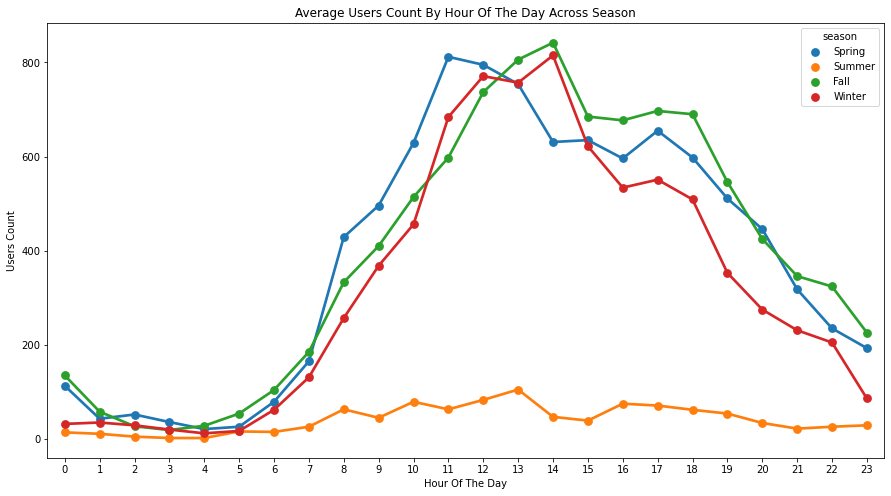

In [124]:
#data = pd.DataFrame({'mean':new_rentals.groupby(["rental_date","rental_hour"], sort=True)["count"].mean()}).reset_index()
fig, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(x=season_freq["lastrentalstart"], y=season_freq["count"], hue=season_freq["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Season")

In [34]:
grouped_rentals['start_battery'].mean(), grouped_rentals['duration'].mean()

(63.06794496161407, 777.2452210600228)

<AxesSubplot:xlabel='start_battery', ylabel='Count'>

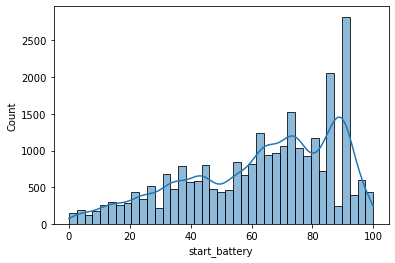

In [35]:
sns.histplot(data=new_rentals, x='start_battery', kde=True)

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini